Right, so let's start by importing some relevant libraries and the datasets from the previous section.

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

***Quick reminder:***
- Group 1: all entries after the data cleaning from section 01;
- Group 2: all extreme outliers removed;
- Group 3: all mild outliers removed (and, consequently, all extreme outliers as well).

In [2]:
# Group 1:
# items1 = pd.read_csv('data/Created in part 01/group1_items.csv', index_col='Invoice', parse_dates=['InvoiceDate'], dtype={'Customer ID': str})
invoices1 = pd.read_csv('../data/Created in part 01/group1_invoices.csv', index_col='Invoice', parse_dates=['InvoiceDate'], dtype={'Customer ID': str})

# Group 2:
# items2 = pd.read_csv('data/Created in part 01/group2_items.csv', index_col='Invoice', parse_dates=['InvoiceDate'], dtype={'Customer ID': str})
# invoices2 = pd.read_csv('data/Created in part 01/group2_invoices.csv', index_col='Invoice', parse_dates=['InvoiceDate'], dtype={'Customer ID': str})

# # Group 3:
# items3 = pd.read_csv('data/Created in part 01/group3_items.csv', index_col='Invoice', parse_dates=['InvoiceDate'], dtype={'Customer ID': str})
# invoices3 = pd.read_csv('data/Created in part 01/group3_invoices.csv', index_col='Invoice', parse_dates=['InvoiceDate'], dtype={'Customer ID': str})

# For this part,
several graphs will be created. Data scientists are good at managing data and creating all sorts of weird stuff, but all these outputs might look confusing for outsiders. Therefore, [Streamlit](https://streamlit.io/) might come in handy, since it is a powerful tool for dashboard creation.

Considering we have 3 groups of different data, it becomes too much time-consuming creating separate functions for each group. We can make things a lot easier by creating general functions that can take any input and return the appropriate output. This will also simplify our Streamlit code, making it faster to develop and easier to cache, if needed be. *By default*, let's use the datasets from Group 1 as the basis for our visualizations and analyses.

Let's get things going:

- # General overview of the data, as time series

In [3]:
invoices1

Quantity   Price Customer ID         InvoiceDate
Invoice                                                  
489434        166   32.65     13085.0 2009-01-12 07:45:00
489435         60   10.50     13085.0 2009-01-12 07:46:00
489436        193   70.88     13078.0 2009-01-12 09:06:00
489437        145   83.45     15362.0 2009-01-12 09:08:00
489438        826   44.05     18102.0 2009-01-12 09:24:00
...           ...     ...         ...                 ...
538167        125   76.15     14713.0 2010-09-12 18:58:00
538168        167   68.95     14702.0 2010-09-12 19:23:00
538169         33   39.20     13230.0 2010-09-12 19:28:00
538170        133   70.54     13969.0 2010-09-12 19:32:00
538171        194  165.58     17530.0 2010-09-12 20:01:00

[20573 rows x 4 columns]

In [4]:
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Scatter(y=invoices1.Price, x=invoices1.InvoiceDate, mode='markers', name='Price'), row=1, col=1)
fig.add_trace(go.Scatter(y=invoices1.Quantity, x=invoices1.InvoiceDate, mode='markers', name='Quantity'), row=1, col=2)
fig.show('svg')

Uh-oh, looks like our data is messy. Invoices before 12/Dec/2009 were all clumped together into the 12th day of the month, therefore, we don't have available data on a daily basis.

Let's see how this would look like if we were to regroup everything into monthly data.

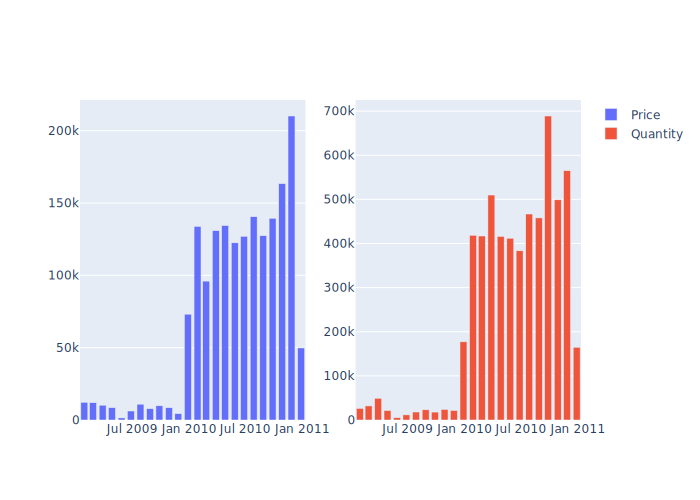

In [5]:
resampled_invoices1 = invoices1.resample(rule='M', on='InvoiceDate').sum()   # grouping by month

fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Bar(y=resampled_invoices1.Price, x=resampled_invoices1.index, name='Price'), row=1, col=1)
fig.add_trace(go.Bar(y=resampled_invoices1.Quantity, x=resampled_invoices1.index, name='Quantity'), row=1, col=2)
# by default, the last day of the month is shown, but the data represents the whole month
fig.show('svg')

Weird, still. To be honest, we should just drop all these data from Nov/2009 backwards.

Also, Dec/2010 seems incomplete and we should just drop it if that is the casse. Let's check.

In [6]:
invoices1.query("InvoiceDate > '2009-11-30'").InvoiceDate.sort_values()[:5]   # querying and sorting data after 30/Nov/2009

Invoice
491648   2009-12-13 09:58:00
491649   2009-12-13 10:28:00
491651   2009-12-13 10:41:00
491652   2009-12-13 10:48:00
491653   2009-12-13 10:50:00
Name: InvoiceDate, dtype: datetime64[ns]

Indeed, data from Dec/2009 starts on the 13th...

In [7]:
invoices1.InvoiceDate.sort_values()[-5:]

Invoice
532639   2010-12-11 16:42:00
532641   2010-12-11 16:59:00
532642   2010-12-11 17:00:00
532643   2010-12-11 17:01:00
532644   2010-12-11 17:32:00
Name: InvoiceDate, dtype: datetime64[ns]

... and Dec/2010 only had purchases up to the 11th day...

Let's also remove both months.

In [8]:
invoices1 = invoices1.query("(InvoiceDate > '2009-12-31') & (InvoiceDate < '2010-12-01')").sort_values('InvoiceDate')

invoices1.head()

Quantity  Price Customer ID         InvoiceDate
Invoice                                                 
496349        228  65.51     14739.0 2010-01-02 08:13:00
496351         79  80.05     14370.0 2010-01-02 08:35:00
496352          4   4.90         NaN 2010-01-02 09:45:00
496354         98  25.61     12810.0 2010-01-02 09:52:00
496355        432   1.69     16684.0 2010-01-02 09:55:00

____

- # Active Customers and Number of Orders (monthly)

In [9]:
invoices1.groupby(invoices1['InvoiceDate'].dt.month_name().str[:3], sort=False).nunique()
# converts InvoiceDate to month-name only, and then gets the first 3 characters

Quantity  Price  Customer ID  InvoiceDate
InvoiceDate                                           
Jan               511   1227          915         1337
Feb               487   1125          813         1195
Mar               540   1333          969         1393
Apr               558   1367          973         1464
May               542   1382          975         1482
Jun               530   1302          940         1384
Jul               570   1453         1023         1628
Aug               566   1392         1002         1499
Sep               615   1596         1150         1781
Oct               593   1699         1264         1790
Nov               622   1915         1392         2057

Ok, columns `Quantity`, `Price` and `InvoiceDate` are quite irrelevant in this dataframe.

The index is wrongly named, so we need to fix that as well.

Let's get this dataframe into a variable and plot it.

***Psst!*** We can do the same thing for the unique number of invoices!

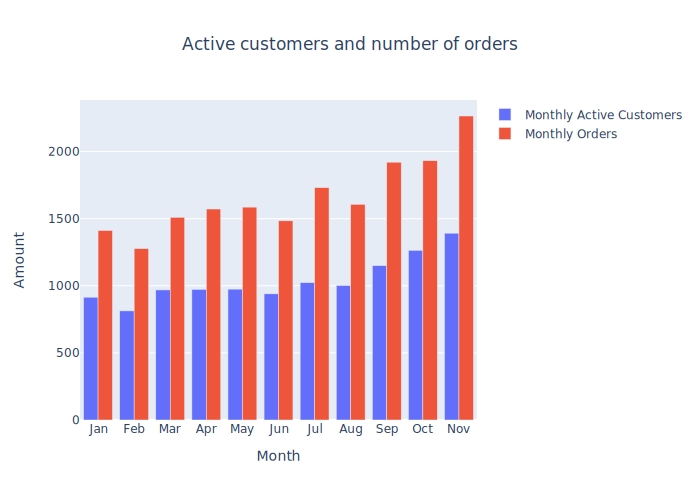

In [10]:
invoices1_monthly_customers = (
        invoices1[['Customer ID']]
        .groupby(invoices1['InvoiceDate'].dt.month_name().str[:3], sort=False)
        .nunique()
)

invoices1_monthly_orders = (
        invoices1[['Price']]   # selecting any column (we just need the number of entries for each month, since each entry is a unique invoice number)
        .groupby(invoices1['InvoiceDate'].dt.month_name().str[:3], sort=False)
        .count()
)   # the column for this dataframe is named 'Price', but we know that it is not the case, right?

fig = go.Figure(data=[
        go.Bar(name='Monthly Active Customers', y=invoices1_monthly_customers['Customer ID'], x=invoices1_monthly_customers.index),
        go.Bar(name='Monthly Orders', y=invoices1_monthly_orders['Price'], x=invoices1_monthly_orders.index)
])
fig.update_layout(title='Active customers and number of orders',
                    title_x=0.5,
                    xaxis_title='Month',
                    yaxis_title='Amount')
fig.show('svg')

____

- # Average revenue per order (monthly)

This is pretty straightforward, so let's do it.

In [11]:
invoices1_avg_revenue = (
        invoices1[['Price']]
        .groupby(invoices1['InvoiceDate'].dt.month_name().str[:3], sort=False)
        .mean()
)

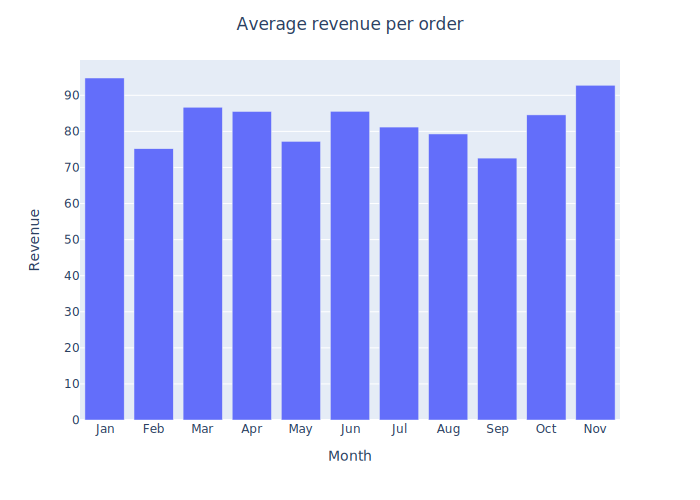

In [12]:
fig = (
    px.bar(data_frame=invoices1_avg_revenue, y='Price')
)
fig.update_layout(title='Average revenue per order',
                    title_x=0.5,
                    xaxis_title='Month',
                    yaxis_title='Revenue')
fig.show('svg')

*While we are at it*, why not make our dataframe prettier and change those long invoice dates for something more neat? (we probably won't be using anything more specific than years, months and days)

In [13]:
invoices1['InvoiceDate'] = invoices1['InvoiceDate'].dt.normalize()

invoices1.head(3)   # so much better!

Quantity  Price Customer ID InvoiceDate
Invoice                                         
496349        228  65.51     14739.0  2010-01-02
496351         79  80.05     14370.0  2010-01-02
496352          4   4.90         NaN  2010-01-02

____

- # Revenue by Customer Type (monthly)

Most of our sales come from existing or new customers? How do we define what is a new customer?

In our analysis, we can define a new customer as someone who made their first purchase in a given month.

Let's group our invoices by customer ID and then get the date of their first purchase, using `min()` (which also works for dates).

**BUT FIRST**, `Customer ID` has NaN values. Since we can't really say if those NaN's are from existing or new customers, we are better off dropping them for our next analyses.

In [14]:
# Dropping NaN's
invoices1 = invoices1.dropna(subset=['Customer ID'])

# Now that we got rid of those pesky NaN's, we can convert this column to int and then to str in order to easily remove those '.0'
# (this could have been done before using pd.options.display.float_format)
invoices1['Customer ID'] = pd.to_numeric(invoices1['Customer ID']).astype(int).astype(str)
invoices1.head()

Quantity  Price Customer ID InvoiceDate
Invoice                                         
496349        228  65.51       14739  2010-01-02
496351         79  80.05       14370  2010-01-02
496354         98  25.61       12810  2010-01-02
496355        432   1.69       16684  2010-01-02
496356        222  62.28       14047  2010-01-02

In [15]:
# Grouping by Customer ID
(
    invoices1
    .groupby('Customer ID')
    ['InvoiceDate']
    .min()
    .dt.month
)

Customer ID
12346     2
12347     7
12348     9
12349     4
12351    11
         ..
18283     2
18284     4
18285     2
18286     8
18287     5
Name: InvoiceDate, Length: 4120, dtype: int64

Good, this gives us the month of the first purchase of each customer, with their ID's as index.

Now we can merge this info into our original dataframe of invoices

In [16]:
first_month_series = (
    invoices1
    .groupby('Customer ID')
    ['InvoiceDate']
    .min()
    .dt.month
    .rename('FirstMonth')
)

invoices1 = invoices1.merge(first_month_series, on='Customer ID').set_axis(invoices1.index)
# merging resets the index, therefore we passed set_axis()

We can easily check if a customer is making their first purchase by comparing the invoice date and the month of their first purchase. If the first is greater than the latter, than it is an existing customer.

In [17]:
# Let's start by assuming all customers are new ones
invoices1['CustomerType'] = 'New'

# Getting all entries where the condition is met, and then getting the index of this resulting dataframe
aux_index = invoices1.query("InvoiceDate.dt.month > FirstMonth").index

# Changing `UserType` of the previously selected invoices
invoices1.loc[aux_index, 'CustomerType'] = 'Existing'

invoices1.iloc[:30]

Quantity  Price Customer ID InvoiceDate  FirstMonth CustomerType
Invoice                                                                  
496349        228  65.51       14739  2010-01-02           1          New
496351        478   8.39       14739  2010-02-09           1     Existing
496354        509  84.83       14739  2010-02-26           1     Existing
496355        132   2.95       14739  2010-03-06           1     Existing
496356        202   9.70       14739  2010-03-23           1     Existing
496357        214  21.81       14739  2010-04-28           1     Existing
496361        240  15.87       14739  2010-05-18           1     Existing
496363        590  20.36       14739  2010-05-27           1     Existing
496370        476  17.95       14739  2010-07-12           1     Existing
496373        104  12.86       14739  2010-07-16           1     Existing
496374        344  70.35       14739  2010-07-28           1     Existing
496381        188   8.05       14739  2010-08-20           1     Existing
496399        330  16.07       14739  2010-09-22           1     Existing
496400         96  35.71       14739  2010-09-30           1     Existing
496407        176  26.78       14739  2010-10-02           1     Existing
496412        444  22.53       14739  2010-10-31           1     Existing
496425         79  80.05       14370  2010-01-02           1          New
496426         69  96.70       14370  2010-03-24           1     Existing
496427         16  58.10       14370  2010-06-05           1     Existing
496428          6   2.55       14370  2010-06-05           1     Existing
496429         48  50.39       14370  2010-08-08           1     Existing
496430         48   2.55       14370  2010-09-15           1     Existing
496431         98  25.61       12810  2010-01-02           1          New
496434        291  36.52       12810  2010-06-23           1     Existing
496436        432   1.69       16684  2010-01-02           1          New
496438       3160  33.83       16684  2010-01-18           1          New
496440       3736  55.09       16684  2010-02-25           1     Existing
496441         37   8.50       16684  2010-04-21           1     Existing
496442       3202  25.36       16684  2010-04-26           1     Existing
496443        492   7.20       16684  2010-04-26           1     Existing

Lookin' good. Now let's group those customer types by month and then plot the results.

In [18]:
# This helper function converts the `InvoiceDate` column to a 3-letter word of the
# respective month. This is just to make our graphs look nicer

def get_month_name(df):
    df2 = df.copy().sort_values(by='InvoiceDate')   # creates a copy of the dataframe
    df2['InvoiceDate'] = df2['InvoiceDate'].dt.month_name()   # converts to month name
    df2['InvoiceDate'] = df2['InvoiceDate'].str[:3]   # gets the first 3 characters
    return df2   # returns the modified dataframe

In [19]:
invoices1_by_type = (
    invoices1.pipe(get_month_name)
    .groupby(['CustomerType', 'InvoiceDate'], as_index=False, sort=False)
    ['Price']
    .sum()
)

fig = go.Figure(data=[
        go.Scatter(
            name='New',
            y=invoices1_by_type.query("CustomerType == 'New'")['Price'],
            x=invoices1_by_type.query("CustomerType == 'New'")['InvoiceDate']),
        go.Scatter(
            name='Existing',
            y=invoices1_by_type.query("CustomerType == 'Existing'")['Price'],
            x=invoices1_by_type.query("CustomerType == 'Existing'")['InvoiceDate']),
        go.Scatter(
            name='Total',
            y=invoices1_by_type.groupby("InvoiceDate", sort=False)['Price'].sum(),
            x=invoices1_by_type.groupby("InvoiceDate", sort=False)['Price'].sum().index)
])
fig.update_layout(title='Monthly revenue by customer type',
                    title_x=0.5,
                    xaxis_title='Month',
                    yaxis_title='Revenue')                   
fig.show()

Existing customers are booming, but new ones are doing poorly... Our sales are increasing, but we can always do better, right?

Let's dig deeper.

___

- # Retetion Rate (monthly)

Retetion rate is an important metric that indicates how well our products fit the market and how sticky is our service.

$ Monthly\_retetion\_rate = \frac{Retained\_customers\_from\_pervious\_month}{Total\_active\_customers} $

The next step is to calculate how many customers were retained from previous month.

In [20]:
invoices1_active_months = (
    invoices1
    .pipe(get_month_name)   # using that old helper function
    .groupby(['Customer ID','InvoiceDate'], as_index=False, sort=False)['Price']
    .sum()
)

invoices1_active_months.head()

Customer ID InvoiceDate  Price
0       14739         Jan  65.51
1       13173         Jan  88.59
2       15369         Jan   5.64
3       15564         Jan   2.92
4       15803         Jan  78.50

In [21]:
# Let's save the calendar order of the months, we are gonna need it in the next step
ordered_months = invoices1_active_months['InvoiceDate'].unique().tolist()

ordered_months

['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']

In [22]:
invoices1_retention = (
    pd.crosstab(
            index=invoices1_active_months['Customer ID'], 
            columns=invoices1_active_months['InvoiceDate'])
    .reindex(columns=ordered_months)   # crosstab messes our month orders, ugh!
)

invoices1_retention

InvoiceDate  Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov
Customer ID                                                       
12346          0    1    0    0    0    1    0    0    0    0    0
12347          0    0    0    0    0    0    1    0    0    1    0
12348          0    0    0    0    0    0    0    0    1    0    0
12349          0    0    0    1    0    0    0    0    0    1    0
12351          0    0    0    0    0    0    0    0    0    0    1
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
18283          0    1    1    0    0    0    0    1    0    0    1
18284          0    0    0    1    0    0    0    0    0    0    0
18285          0    1    0    0    0    0    0    0    0    0    0
18286          0    0    0    0    0    0    0    1    0    0    0
18287          0    0    0    0    1    0    0    0    1    0    1

[4120 rows x 11 columns]

What an amazing retention matrix! Now let's create a list and populate it with dictionaries containing:

1. Month;
2. The total number of customers for that month;
3. The number of retained customers, from the previous month.

In [23]:
retention_array = []

for i in range(len(ordered_months)-1):
    retention_data = {}
    selected_month = ordered_months[i+1]
    previous_month = ordered_months[i]
    retention_data['Month'] = selected_month
    retention_data['TotalCustomers'] = invoices1_retention[selected_month].sum()
    retention_data['RetainedCustomers'] = invoices1_retention.query(f"({selected_month} > 0) & ({previous_month} > 0)")[selected_month].sum()
    retention_array.append(retention_data)

Although it was looking pipin' hot, that retention matrix was only needed to create a dataframe with the total customers of each month and the number of retained customers.

Let's replace that dataframe with a new one created using our `retention_array` list of dictionaries.

In [24]:
invoices1_retention = pd.DataFrame(retention_array)
invoices1_retention['RetentionRate'] = invoices1_retention['RetainedCustomers']/invoices1_retention['TotalCustomers']

invoices1_retention

Month  TotalCustomers  RetainedCustomers  RetentionRate
0   Feb             813                272       0.334563
1   Mar             969                283       0.292054
2   Apr             973                353       0.362795
3   May             975                346       0.354872
4   Jun             940                349       0.371277
5   Jul            1023                340       0.332356
6   Aug            1002                378       0.377246
7   Sep            1150                385       0.334783
8   Oct            1264                433       0.342563
9   Nov            1392                502       0.360632

...and finally!

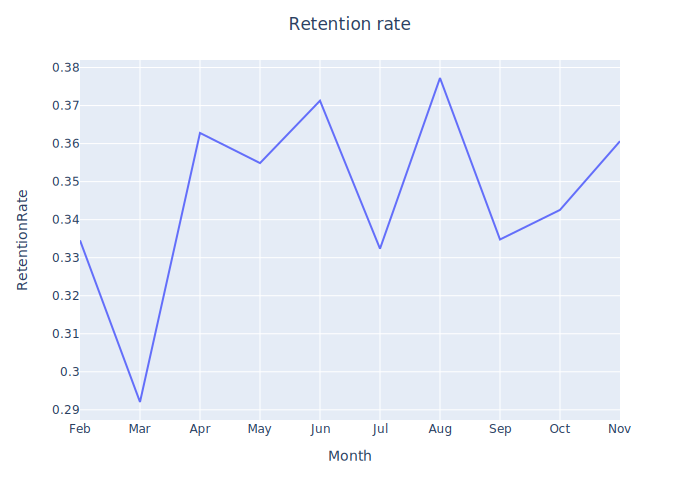

In [25]:
fig = (
    px.line(
        data_frame=invoices1_retention,
        y='RetentionRate',
        x='Month')
)
fig.update_layout(title='Retention rate',
                    title_x=0.5
)

fig.show('svg')

In a given month, a little less than 40% of the customers that purchased something also complete a purchase in the previous month.

Can the company's marketing team increase customer retention with new campaigns? Maybe...

In [26]:
# Suggestion: add to the previous plot a line graph showing the % of revenue that these
# retained customers out of the total revenue for each month

___

Hooray, we've made it to the end of another section!

$~$ 

# WAIT, WHAT?

## What about the other 2 groups? What about Streamlit?

$~$ 

Worry no more, child, we are gonna cover both topics all at once! The next steps are:

1. Create a helper `utils.py` script with all the necessary functions from this notebook, i.e., convert all the code in this notebook to something concise that can be easily applied to any of the other group's dataframes (**HINT**: this is a good opportunity to practice docstringing!);
2. Create a clean code for our Streamlit dashboard, using the functions in `utils.py`. 

I invite you to check `utils.py` and then the Streamlit script (file `02b - Streamlit script.py`) in this git repo.

See you there!